In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math

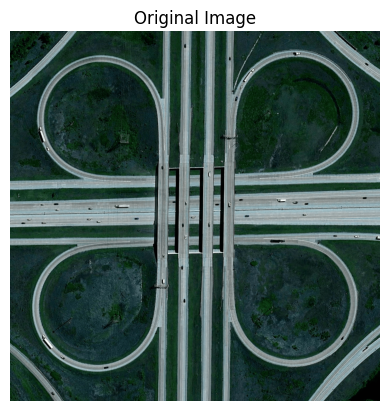

Dimensions: (1207, 1207, 3)
Pixel Value Range: 0 to 253
Color Channels Info:
  Red - Min: 0, Max: 249, Mean: 53.78
  Green - Min: 1, Max: 253, Mean: 77.64
  Blue - Min: 1, Max: 250, Mean: 72.30


In [2]:
def load_cloverleaf_image(filepath):
    
    image = cv2.imread(filepath, cv2.IMREAD_COLOR)
    image_array = np.array(image)
    

    plt.imshow(image_array)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    print(f"Dimensions: {image.shape}") 
    print(f"Pixel Value Range: {image_array.min()} to {image_array.max()}")
    
    # Separate channels for color image
    if len(image_array.shape) == 3:  
        print("Color Channels Info:")
        for i, channel in enumerate(['Red', 'Green', 'Blue']):
            channel_data = image_array[:, :, i]
            print(f"  {channel} - Min: {channel_data.min()}, Max: {channel_data.max()}, Mean: {channel_data.mean():.2f}")
    else:
        # Grayscale image
        print(f"Mean Pixel Value: {image_array.mean():.2f}")
        print(f"Standard Deviation: {image_array.std():.2f}")
        
    return image

image_path = "cloverleaf_interchange.png"
image = load_cloverleaf_image(image_path)

#### Comparing histograms

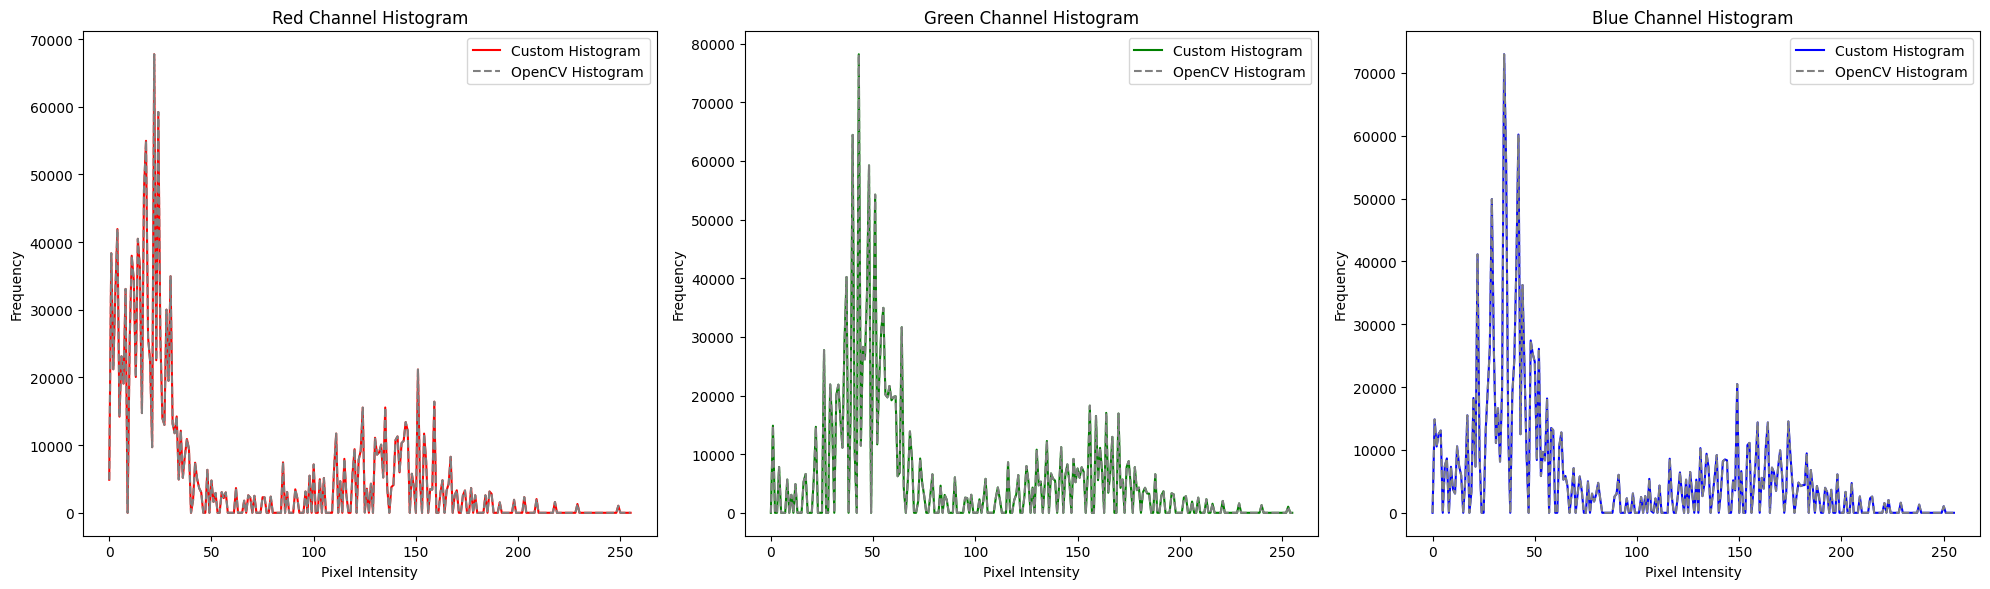

In [9]:
def custom_histogram(image, channel):
    """
    Compute the custom histogram for a specific channel of the image.
    """
    channel_data = image[:, :, channel]
    hist = np.zeros(256, dtype=int) 
    
    for value in channel_data.flatten():
        hist[value] += 1
    
    return hist

def compare_histograms(image):
    # Check if the image is RGB
    if len(image.shape) != 3 or image.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel RGB image.")
    
    channel_labels = ['Red', 'Green', 'Blue']
    colors = ['r', 'g', 'b']  
    
    plt.figure(figsize=(20, 6))
    
    for channel in range(3):  
        # Compute custom histogram
        custom_hist = custom_histogram(image, channel)
        
        # Compute OpenCV histogram
        opencv_hist = cv2.calcHist([image], [channel], None, [256], [0, 256]).flatten()
        
        plt.subplot(1, 3, channel + 1)
        plt.plot(custom_hist, label='Custom Histogram', linestyle='solid', color=colors[channel])
        plt.plot(opencv_hist, label='OpenCV Histogram', linestyle='dashed', color='gray')
        plt.title(f"{channel_labels[channel]} Channel Histogram")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        
    plt.show()
    
compare_histograms(image)

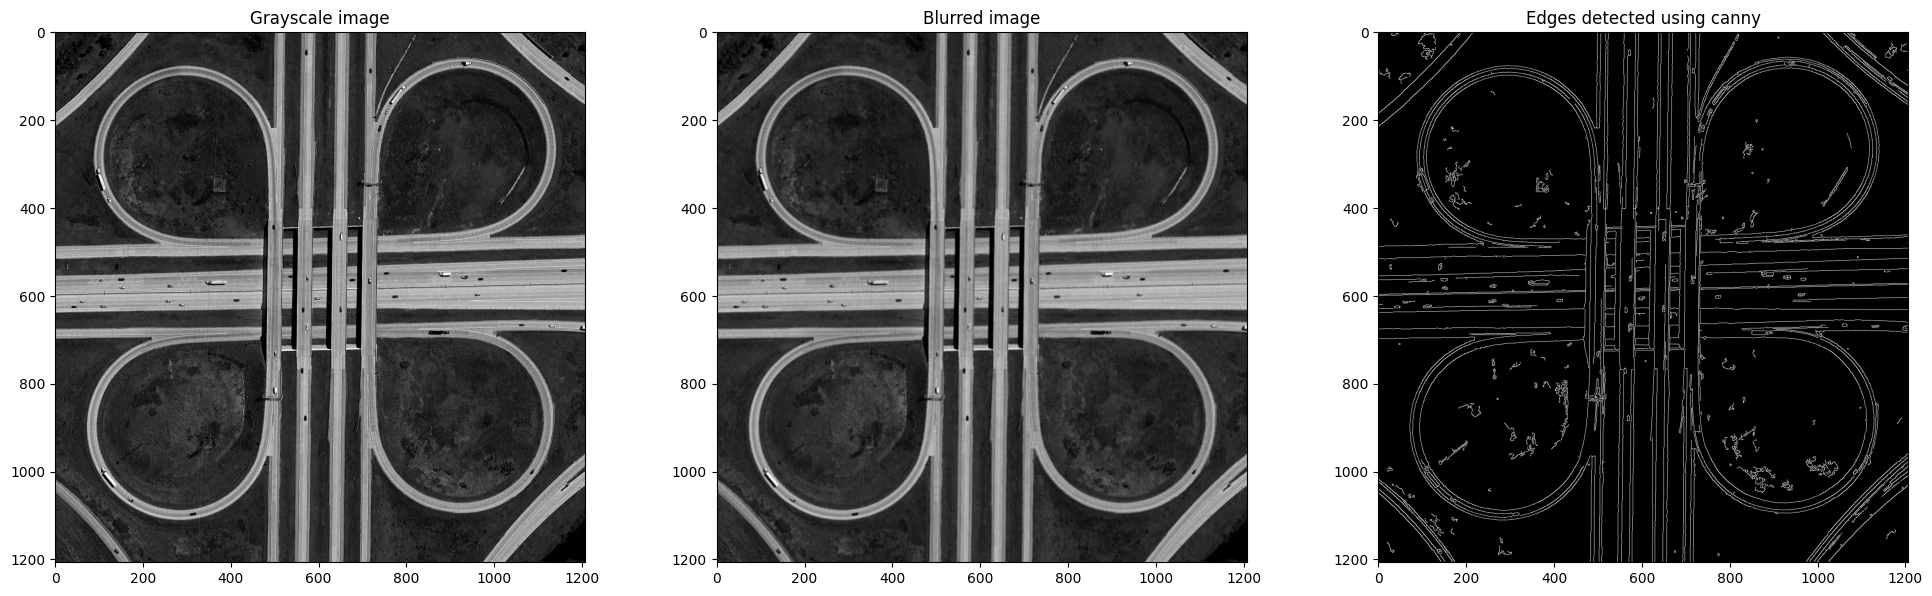

In [4]:
def preprocess_image(image):
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction using Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Edge detection using Canny
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    
    plt.figure(figsize=(20, 6))
    
    plt.subplot(1,3,1)
    plt.title("Grayscale image")
    plt.imshow(gray, cmap='gray')
    
    plt.subplot(1,3,2)
    plt.title("Blurred image")
    plt.imshow(blurred, cmap='gray')
    
    plt.subplot(1,3,3)
    plt.title("Edges detected using canny")
    plt.imshow(edges, cmap='gray')
    
    plt.tight_layout()
    
    plt.show()
        
    return edges

preprocessed_image = preprocess_image(image)

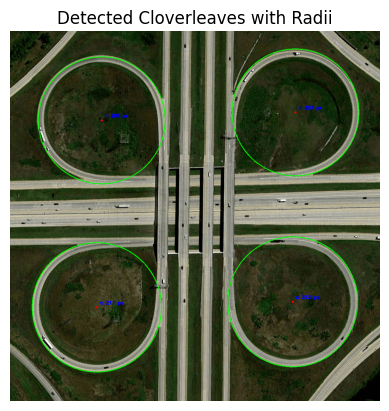

Detected circles:
Circle 1: Center = (283, 901), Radius = 211 pixels
Circle 2: Center = (922, 883), Radius = 212 pixels
Circle 3: Center = (931, 265), Radius = 207 pixels
Circle 4: Center = (299, 291), Radius = 207 pixels


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_cloverleaves(image, preprocessed_image):
    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(
        preprocessed_image,
        cv2.HOUGH_GRADIENT,
        dp=1.2,           # Inverse ratio of accumulator resolution to image resolution
        minDist=70,       # Minimum distance between detected circles
        param1=50,        # Gradient value for edge detection (Canny)
        param2=30,        # Accumulator threshold for circle detection
        minRadius=205,    # Minimum radius of circles
        maxRadius=213     # Maximum radius of circles
    )
    
    # Draw detected circles on the original image
    output_image = image.copy()
    detected_circles = []
    
    if circles is not None:
        circles = np.uint16(np.around(circles))  # Round to integers
        for circle in circles[0, :]:
            x, y, r = circle
           
            cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Draw the circle's perimeter
            cv2.circle(output_image, (x, y), 2, (0, 0, 255), 3)   # Draw the circle's center
            detected_circles.append((x, y, r))
            
            # Display the radius on the image
            cv2.putText(output_image, f"r: {r} px", 
                        (x + 10, y - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Detected Cloverleaves with Radii")
    plt.axis('off')
    plt.show()
    
    # Return the output image and the list of detected circles
    return output_image, detected_circles

output_image, detected_circles = detect_cloverleaves(image, preprocessed_image)

# Step 4: Print details of detected circles
if detected_circles:
    print("Detected circles:")
    for i, circle in enumerate(detected_circles, 1):
        print(f"Circle {i}: Center = ({circle[0]}, {circle[1]}), Radius = {circle[2]} pixels")
else:
    print("No circles detected.")


#### Circle Detection via Hough Transform:
+ The Hough Circle Transform detects circles in the binary edge-detected image (post preprocessing). It uses a parametric representation of a circle (defined by its center coordinates (x, y) and radius r), and searches for circular patterns in the edge map generated by the Canny edge detector.
+ This transform works by detecting patterns of edge points that fit the equation of a circle. The result is a set of potential circles with their centers and radii.

Information Needed to Calculate the Radius:
1. Center (x, y): The center of the detected circle is determined as part of the circle's parameters during the Hough Circle Transform. This is useful for locating the position of the circle in the image.
2. Radius (r): The radius of the detected circle is directly provided by the Hough Circle Transform. The radius is calculated based on the distance from the center to the boundary of the circle in the image. This value is provided in pixels and represents the size of the circle in the image space.
After detecting the circles, we use the radius information directly from the Hough Circle Transform to label the circles and print the radius in pixels.


### Preprocessing Techniques and Impact

- Grayscale Conversion: Reduced the complexity of the image by removing color information, focusing only on intensity variations.
- Gaussian Blur: Smoothed the image to reduce noise and ensure more consistent edge detection.
- Canny Edge Detection: Highlighted the boundaries of objects, making it easier to identify potential circles in the image.

Impact of Preprocessing:

- Noise reduction using Gaussian Blur significantly improved the quality of edge detection.
- Edge detection was critical in isolating circular features while minimizing interference from other shapes or artifacts.
Proper preprocessing enhanced the accuracy of the Hough Circle Transform, ensuring fewer false positives.

### Parameter Choices and Rationale
1. `dp=1.2`: Maintained a good balance between accuracy and computational efficiency by setting the inverse ratio of accumulator resolution to image resolution.
2. `minDist=70`: Ensured that detected circles were spaced sufficiently apart to avoid overlapping detections.
3. `param1=50`: Defined the threshold for edge detection in the Canny algorithm, ensuring prominent edges were detected.
4. `param2=30`: Set the accumulator threshold for circle detection, filtering out weak detections.
5. `minRadius=205 and maxRadius=213`: Constrained the radius range based on the approximate size of the cloverleaves in the image, reducing false positives.

### Challenges Faced:

1. Slight distortions in the shape of the cloverleaves made it difficult to detect perfect circles.
2. Variations in lighting and noise in the image introduced artifacts that interfered with edge detection.
3. Fine-tuning parameters for the Hough Circle Transform to detect cloverleaves without including unrelated structures was non-trivial.

### Potential Failures:

1. Distorted Shapes: Cloverleaves with irregular distortions might not be detected as circles.
2. Overlapping Circles: Overlapping or closely packed cloverleaves could lead to merged detections.
3. Lighting Variations: Shadows or highlights in the image might result in incomplete or false detections.
4. Noise and Artifacts: High levels of noise could interfere with edge detection, reducing accuracy.

Discussion:

The algorithm works best when the cloverleaves are clearly defined with minimal distortion.
In cases of overlapping or irregularly shaped cloverleaves, the detection might need refinement or additional post-processing steps.
To address lighting variations, adaptive thresholding could be explored as an alternative to Canny edge detection.

##

### Area calculation

In [ ]:
import numpy as np
import math
import cv2

def calculate_area(image, circles):
    circles = np.array(circles, dtype=np.float32)

    print(f"Type of circles: {type(circles)}")
    print(f"Shape of circles: {circles.shape}")
    print(f"Contents of circles: {circles}")

    formula_areas = []
    
    # Method 1: Approximate area using the radius of each circle
    if len(circles.shape) == 3 and circles.shape[1:] == (1, 3): 
        for circle in circles[0, :]:
            x, y, r = circle
            area_approx = math.pi * r * r
            formula_areas.append(area_approx)
    elif len(circles.shape) == 2 and circles.shape[1] == 3: 
        for circle in circles:
            x, y, r = circle
            area_approx = math.pi * r * r
            formula_areas.append(area_approx)
    else:
        raise ValueError("Circles array format is unexpected. Check its dimensions.")

    # Method 2: Count the pixels within the detected circle
    pixel_areas = []
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    for i, circle in enumerate(circles):
        x, y, r = circle
        
        # Create a binary mask where pixels inside the circle are 1 and outside are 0
        mask = np.zeros_like(gray_image, dtype=np.uint8)
        cv2.circle(mask, (int(x), int(y)), int(r), 255, -1)
        
        pixel_area = np.sum(mask > 0)
        pixel_areas.append(pixel_area)

    # Display results
    print("Area using radius approximation (in square pixels):")
    for i, area in enumerate(formula_areas):
        print(f"Circle {i+1}: {area:.2f} square pixels")
    
    print("Area using pixel counting (in square pixels):")
    for i, area in enumerate(pixel_areas):
        print(f"Circle {i+1}: {area} square pixels")

    return formula_areas, pixel_areas

areas, pixel_areas = calculate_area(image, detected_circles)

Type of circles: <class 'numpy.ndarray'>
Shape of circles: (4, 3)
Contents of circles: [[283. 901. 211.]
 [922. 883. 212.]
 [931. 265. 207.]
 [299. 291. 207.]]
Area using radius approximation (in square pixels):
Circle 1: 139866.85 square pixels
Circle 2: 141195.74 square pixels
Circle 3: 134614.10 square pixels
Circle 4: 134614.10 square pixels
Area using pixel counting (in square pixels):
Circle 1: 139809 square pixels
Circle 2: 141165 square pixels
Circle 3: 134565 square pixels
Circle 4: 134565 square pixels


### Formula-based vs. Pixel Counting: 
The areas calculated by the two methods are very close to each other, with differences in the range of 30 to 80 square pixels. This is expected, as the formula-based approach assumes a perfect circular shape and uniform pixel distribution, while the pixel counting method considers the actual pixel layout and may account for imperfections in the circle shape or pixel representation.
